In [1]:
#Import statements
import matplotlib.pyplot as plt
from utils import frogdata
from pathlib import Path
import re

## Pulse Overlay + Measured FROG Traces

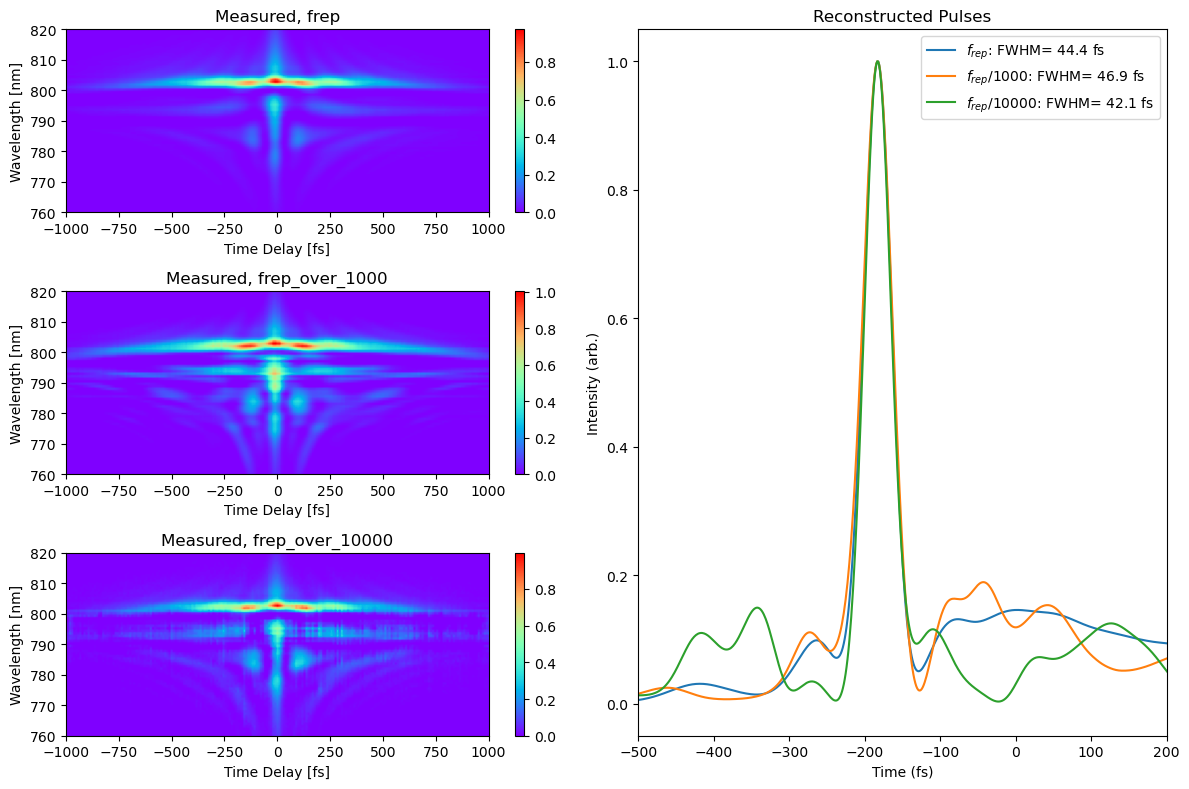

In [4]:
# File management
frog_path = Path(
    r'C:\Users\wahlm\Documents\School\Research\Allison\Tunable Pump\Data for Papers\Tunable seed\FROGs vs. pulse pattern\Low rep rate')
savepath = frog_path.parent / 'rep_rate_vs_pulse_norm_axis.eps'
pattern = r'.*'
sort = lambda frog: 0 if re.search(r'\d+', frog.label) is None else int(re.search(r'\d+', frog.label)[0])
label = lambda name: r'$f_{rep}$' if re.search(r'\d+', frog.label) is None else r'$f_{rep}/$' + (re.search(r'\d+', name)[0])
save_files = False

# Plotting options
panels = [['Trace 0', 'Pulses'],
          ['Trace 1', 'Pulses'],
          ['Trace 2', 'Pulses']]
cmap = 'rainbow'
f, ax = plt.subplot_mosaic(mosaic=panels, figsize=(12,8))

ax['Pulses'].set_xlabel('Time (fs)')
ax['Pulses'].set_ylabel('Intensity (arb.)')
ax['Pulses'].set_title('Reconstructed Pulses')
ax['Pulses'].set_xlim([-500, 200])

for i in range(3):
    ax[f'Trace {i}'].set_ylim([760, 820])
    ax[f'Trace {i}'].set_xlim([-1000, 1000])
    ax[f'Trace {i}'].set_xlabel('Time Delay [fs]')
    ax[f'Trace {i}'].set_ylabel('Wavelength [nm]')

    
fullscreen = False

# Do the thing
frogs = frogdata.read_frog_directory(frog_path, pattern=pattern)
frogs = sorted(frogs, key=sort)
frogs = [frogs[0], frogs[4], frogs[5]]
for i, frog in enumerate(frogs):
    # Fix the phase signs to all be the same (pulse maximum on the left of the plot)
    if frog.pulse_time[frog.pulse_intensity == max(frog.pulse_intensity)] > frog.pulse_time[
                                                                int(len(frog.pulse_time) / 2)]:
        frog.pulse_intensity = frog.pulse_intensity[::-1]

    # Have all the maxima overlap one another in time
    frog.pulse_time = frog.pulse_time - (frog.pulse_time[frog.pulse_intensity == max(frog.pulse_intensity)] -
                                            frogs[0].pulse_time[frogs[0].pulse_intensity == max(frogs[0].pulse_intensity)])

    # Plot the pulse
    
    # Plot the trace
    map = ax[f'Trace {i}'].imshow(frog.trace, aspect='auto', extent=[min(frog.delays), max(frog.delays), min(frog.wavelengths),
                                                      max(frog.wavelengths)], cmap=cmap)
    plt.colorbar(map)
    ax['Pulses'].plot(frog.pulse_time, frog.pulse_intensity, label=f'{label(frog.label)}: FWHM={frog.t_FWHM: .1f} fs')
    ax[f'Trace {i}'].set_title(f'Measured, {frog.label}')

ax['Pulses'].legend()    
if fullscreen:
    f.canvas.manager.window.showMaximized()  # toggle fullscreen mode
plt.tight_layout()
if save_files:
    plt.savefig(savepath, dpi=500)
plt.show()


## Spectra by Pulse Pattern

AttributeError: 'FigureManagerBase' object has no attribute 'window'

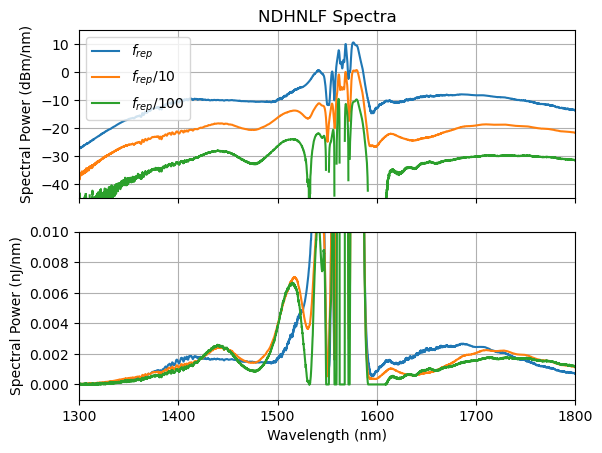

In [6]:
# Plots every spectrum in a user-selected folder. Works for the Yokogawa spectrometer.
import matplotlib.pyplot as plt
from utils.spectrometerdata import OSAData, readFromFiles
from pathlib import Path

if __name__ == "__main__":
    directorypath = Path(
        r'C:\Users\wahlm\Documents\School\Research\Allison\Tunable Pump\Pulse Optimization and Spectrum Generation\10-5-23 Optimized 4cm ND spectra\42cm\Post pulser optimization')
    raw_data = readFromFiles(directorypath)
    labels = (r'$f_{rep}$',
              r'$f_{rep}/10$',
              r'$f_{rep}/100$',
              'background'
              )
    frep_frac = [1, 1/10, 1/100, 0]
    is_background = (False, False, False, True)   
    powers_mW = [191, 33, 15.37, 13.9]

    data = [OSAData(dat, ('nm', 'dBm/nm'), labels[i], powers_mW[i], frep_MHz=frep_frac[i] * 60.56, is_background=is_background[i]) for i, dat in enumerate(raw_data)]
    # data = data[:-1]
    # Background subtraction
    for datum in data:
       datum.y_axis_units = 'mW/nm'
    for i, datum in enumerate(data[:-1]):
        datum.y_axis_data = datum.y_axis_data - (1 - frep_frac[i]) * data[-1].y_axis_data
        datum.total_power_mW = datum.total_power_mW - (1 - frep_frac[i]) * data[-1].total_power_mW 
    
    data = data[:-1]   
        
    fig, axs = plt.subplots(2, 1, sharex=True)

    for datum in data:
        datum.y_axis_units = 'dBm/nm'
        axs[0].plot(datum.x_axis_data, datum.y_axis_data, label=datum.label)
    # axs[0].set_xlabel('Wavelength (nm)')
    axs[0].set_ylabel(f'Spectral Power ({data[0].y_axis_units})')
    axs[0].legend()
    axs[0].set_title('NDHNLF Spectra')
    axs[0].grid()


    for datum in data:
        datum.y_axis_units = 'nJ/nm'
        axs[1].plot(datum.x_axis_data, datum.y_axis_data, label=datum.label)
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel(f'Spectral Power ({data[0].y_axis_units})')
    axs[1].grid()



    for ax in axs.flatten():
        ax.set_xlim([1300, 1800])
    axs[0].set_ylim([-45, 15])
    axs[1].set_ylim([-.001, .01])
    # axs[1].set_ylim([-45, 10])

    
    fig.canvas.manager.window.showMaximized()  # toggle fullscreen mode
    plt.tight_layout()
    plmt.show()


## Pulses

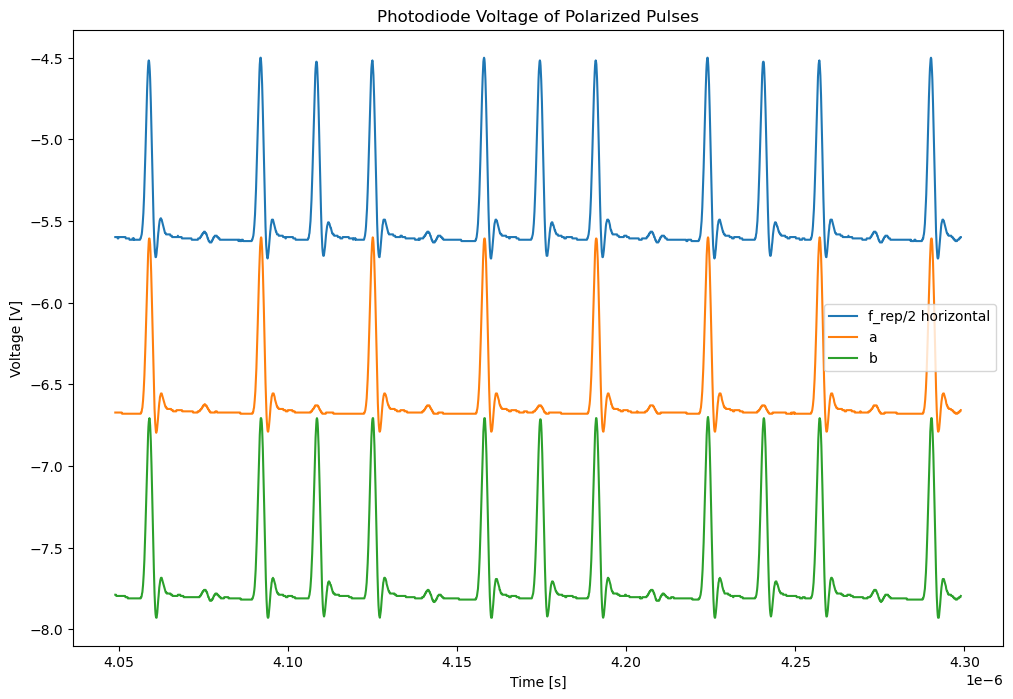

In [9]:
# Plots every scope lineout in user-selected folder. Works for Tektronix scopes
from pathlib import Path
import matplotlib.pyplot as plt
from utils.plotting_utils import directory_to_dataframes, get_scope_data, normalize_by_maximum


save_fig = False
filename = 'frep_over_4_scope_trace'
directorypath = Path(r'C:\Users\wahlm\Documents\School\Research\Allison\Tunable Pump\Polarization Control\10-6-23 Pulser Reoptimization')
dfs = directory_to_dataframes(directorypath)
labels = (
            'f_rep/4 vertical',
            'f_rep vertical',
            'f_rep/2 vertical',
            'f_rep/2 horizontal',
            'f_rep horizontal',
            'f_rep/4 horizontal',
            'a',
            'b',
            'c'
            )
data = get_scope_data(dfs, labels)
normalize_by_maximum(data, 'voltage_V')
plot_order = [0, 1, 3, 5, 2, 4, 6,7 , 8]

# Create a figure and axis object using matplotlib
fig, ax = plt.subplots(figsize=(12, 8))

for i, tup in enumerate(sorted(data.items(), key=lambda x: plot_order[labels.index(x[0])])):
    if i > 4:
        ax.plot(tup[1]['time_s'], tup[1]['voltage_V'] - i * 1.1, label=tup[0])
# Add axis labels and a legend
ax.set_xlabel('Time [s]')
ax.set_ylabel('Voltage [V]')
ax.legend()
# ax.set_title('Photodiode output')
ax.set_title('Photodiode Voltage of Polarized Pulses')
# Display the plot
if save_fig:
    fig.savefig(directorypath.parent / filename, dpi=300)
plt.show()
